In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import albumentations
import torchvision.transforms as transforms
import torchvision

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
from sparse_feature_pyramid.model import SparseFeaturePyramidAutoencoder
from sparse_feature_pyramid.data import SevenScenesDataModule
from sparse_feature_pyramid.utils import UniversalFactory
from sparse_feature_pyramid.utils.clearml_figure_reporter import ClearmlFigureReporter

factory = UniversalFactory([SparseFeaturePyramidAutoencoder])

In [4]:
from clearml import Task, Logger

In [5]:
task = Task.init(project_name="sparse-feature-pyramid", task_name="Sparse feature pyramid on local machine",
                 auto_connect_frameworks={'matplotlib': False, 'tensorflow': True, 'tensorboard': True, 
                                          'pytorch': True, 'xgboost': True, 'scikit': True, 'fastai': True,
                                          'lightgbm': True, 'hydra': True})

ClearML Task: created new task id=49d426e08832478eb4fc09d5ff9de23b
CLEARML new package available: UPGRADE to v1.1.2 is recommended!
Release Notes:
### Bug Fixes

- Fix PyJWT issue (limit dependency to `<2.2.0`)
ClearML results page: https://app.community.clear.ml/projects/d9943ce0df704ec4a0feddd4bf78762f/experiments/49d426e08832478eb4fc09d5ff9de23b/output/log


# Load datamodule

In [6]:
data_module_parameters = {
    "batch_size": 64,
    "num_workers": 4,
    "image_size": 128,
    "scenes": ["fire", "chess", "pumpkin", "stairs", "heads", "office", "redkitchen"],
    "center_crop": True,
    "random_jitter": True,
    "random_rotation": True,
    "root_dataset_path": "/media/mikhail/Data3T/7scenes"
}
task.connect(data_module_parameters)
scene = data_module_parameters["scenes"][0]
data_module = SevenScenesDataModule(**data_module_parameters)

[ToyDataModule] - train subset size 26000
[ToyDataModule] - validation dataset size 17000


# Model

In [7]:
model_parameters = AttributeDict(
    name="SparseFeaturePyramidAutoencoder",
    optimizer=AttributeDict(),
    feature_dimensions=[8, 16, 32, 64, 128],
    size_loss_koef=1 / 500000.,
    input_dimension=3,
)
task.connect(model_parameters)
model = factory.make_from_parameters(model_parameters)
model.set_figure_reporter(ClearmlFigureReporter())

# Trainer

In [8]:
logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 100,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name=scene),
    callbacks=[model_checkpoint],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [53]:
%matplotlib agg
trainer.fit(model, data_module);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _encoder_blocks      | ModuleList | 294 K 
1 | _decoder_blocks      | ModuleList | 680 K 
2 | _input_convolution   | Sequential | 824   
3 | _output_convolutions | ModuleList | 6.7 K 
4 | _mask_convolutions   | ModuleList | 2.2 K 
5 | _loss                | MSELoss    | 0     
----------------------------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.942     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
task.close()

In [10]:
checkpoint = torch.load("/home/mikhail/.clearml/cache/lightning_logs/sparse_feature_pyramid/fire/version_87/checkpoints/epoch=69-step=28489.ckpt")
model.load_state_dict(checkpoint["state_dict"])

2021-10-14 16:54:05,729 - clearml.model - INFO - Selected model id: a176d569eaf54641824c7f6bdde91cea
2021-10-14 16:54:07,834 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=49d426e08832478eb4fc09d5ff9de23b, name=epoch=69-step=28489, model=a176d569eaf54641824c7f6bdde91cea, type=input)


<All keys matched successfully>

# Show results

In [16]:
%matplotlib inline
batch = None
for x in data_module.test_dataloader():
    batch = x
    break

In [17]:
def get_image(batch, index):
    input_image = batch["image"][index].detach().cpu().numpy().transpose(1, 2, 0)
    input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
    input_image = np.clip(input_image, 0, 1)
    return input_image

In [36]:
model.eval()
output = model(batch["image"])

(-0.5, 127.5, 127.5, -0.5)

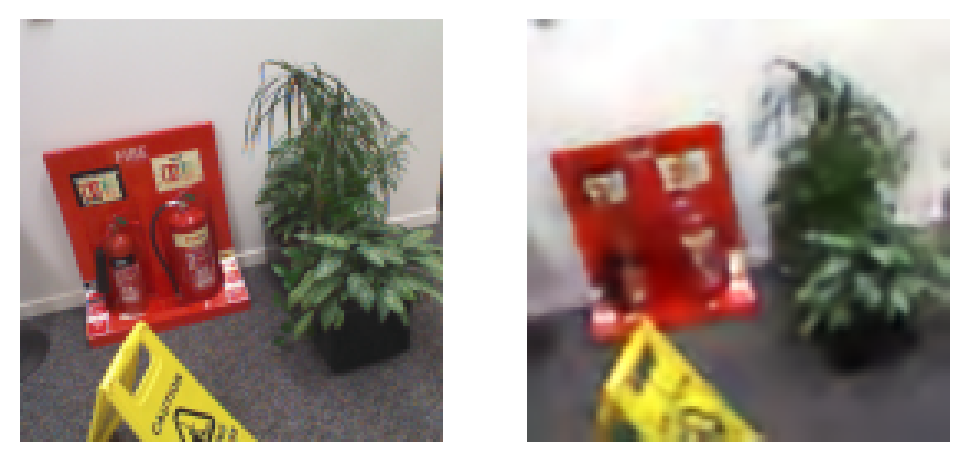

In [37]:
fig, ax = plt.subplots(1, 2, dpi=200)
output_image = output[0][0][0].detach().cpu().numpy().transpose(1, 2, 0)
output_image = output_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
output_image = np.clip(output_image, 0, 1)
ax[1].imshow(output_image)

input_image = torch.nn.functional.interpolate(batch["image"], size=output_image.shape[:2])
input_image = input_image[0].detach().cpu().numpy().transpose(1, 2, 0)
input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
input_image = np.clip(input_image, 0, 1)
ax[0].imshow(input_image)
ax[0].axis('off')
ax[1].axis('off')

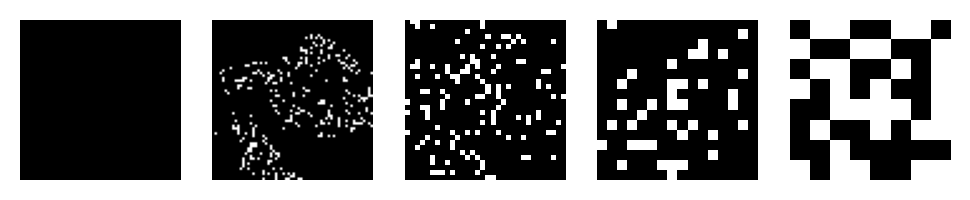

In [38]:
fig, ax = plt.subplots(1, 5, dpi=200)
for i in range(5):
    mask = output[2][i][0][0].detach().cpu().numpy()
    ax[i].imshow(mask, cmap="gray")
    ax[i].axis('off')

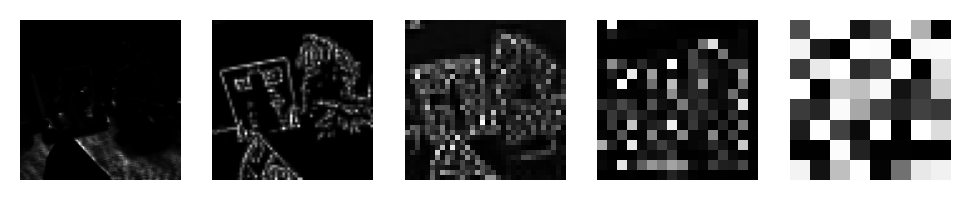

In [39]:
fig, ax = plt.subplots(1, 5, dpi=200)
for i in range(5):
    mask = output[3][i][0][0].detach().cpu().numpy()
    ax[i].imshow(mask, cmap="gray")
    ax[i].axis('off')

(-0.5, 127.5, 127.5, -0.5)

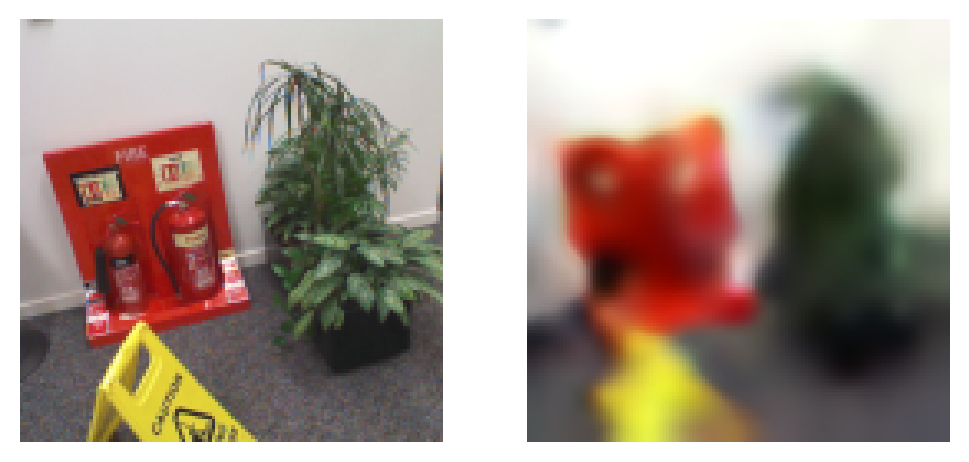

In [41]:
masked_feature_pyramid = [feature * mask for feature, mask in zip(output[1], output[2])]
# masked_feature_pyramid = [feature * torch.where(probability > 0.3, 1., 0.) for 
#                           feature, probability in zip(output[1], output[3])]
# masked_feature_pyramid[4] = torch.zeros_like(masked_feature_pyramid[4])
# masked_feature_pyramid[3] = torch.zeros_like(masked_feature_pyramid[3])
masked_feature_pyramid[2] = torch.zeros_like(masked_feature_pyramid[2])
masked_feature_pyramid[1] = torch.zeros_like(masked_feature_pyramid[1])
masked_feature_pyramid[0] = torch.zeros_like(masked_feature_pyramid[0])

x = masked_feature_pyramid[-1]
for i in range(len(model._decoder_blocks)):
    if i != 10:
        x = model._decoder_blocks[i](x, masked_feature_pyramid[-i - 2])
    else:
        x = model._decoder_blocks[i](x * output[2][-i - 1], masked_feature_pyramid[-i - 2])

output_image = model._output_convolutions[0](x)
fig, ax = plt.subplots(1, 2, dpi=200)
output_image = output_image[0].detach().cpu().numpy().transpose(1, 2, 0)
output_image = output_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
output_image = np.clip(output_image, 0, 1)
ax[1].imshow(output_image)

input_image = torch.nn.functional.interpolate(batch["image"], size=output_image.shape[:2])
input_image = input_image[0].detach().cpu().numpy().transpose(1, 2, 0)
input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
# input_image = np.clip(input_image, 0, 1)
ax[0].imshow(input_image)
ax[0].axis('off')
ax[1].axis('off')

### Probabibilites sum

In [42]:
sum([torch.sum(x[3]) for x in output[3]])

tensor(460.1403, grad_fn=<AddBackward0>)

# PCA analysis of descriptors

In [43]:
from sklearn.decomposition import PCA

In [44]:
level = 1
descriptors = output[1][level].detach().cpu().numpy()
descriptor_dimension = descriptors.shape[1]
image_size = descriptors.shape[2]
descriptors = descriptors.transpose(0, 2, 3, 1).reshape(-1, descriptor_dimension)
descriptors = descriptors / (np.linalg.norm(descriptors, axis=1)[:, None] + 1e-9)

In [45]:
image_descriptors = output[1][level][1].detach().cpu().numpy().transpose(1, 2, 0).reshape(-1, descriptor_dimension)
image_descriptors = image_descriptors / (np.linalg.norm(image_descriptors, axis=1)[:, None] + 1e-9)
image_descriptors.shape

(4096, 16)

In [46]:
pca = PCA(n_components=3).fit(descriptors)
pca_descriptors = pca.transform(image_descriptors)
max_c = np.max(pca_descriptors)
min_c = np.min(pca_descriptors)
colored_descriptors = np.clip((pca_descriptors - min_c) / (max_c - min_c), 0, 1).reshape(image_size, image_size, 3)

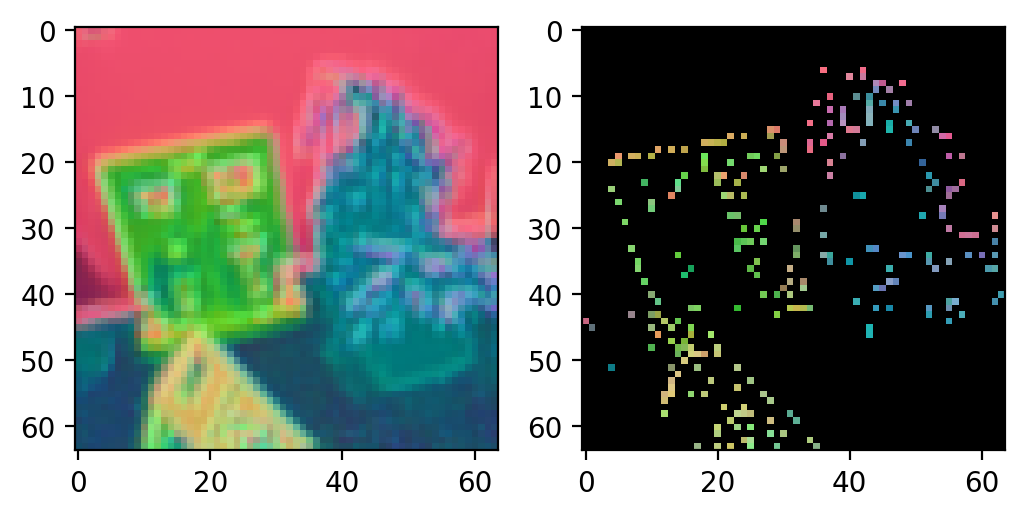

In [47]:
fig, ax = plt.subplots(1, 2, dpi=200)
mask = output[2][level][1][0].detach().cpu().numpy()
ax[0].imshow(colored_descriptors)
ax[1].imshow(colored_descriptors * mask[:, :, None])

# Match points 

In [48]:
from kapture_localization.matching.matching import MatchPairNnTorch
from torch.nn.functional import grid_sample
import torch

In [49]:
def get_keypoint_grid(output, level):
    descriptors = output[1][level]
    height = descriptors.shape[2]
    width = descriptors.shape[3]
    batch_size = descriptors.shape[0]
    x, y = np.meshgrid(range(height), range(width))
    keypoints = np.array([x, y]).transpose(1, 2, 0).astype(np.float32)
    keypoints[:, :, 0] = 2 * keypoints[:, :, 0] / (width - 1) - 1
    keypoints[:, :, 1] = 2 * keypoints[:, :, 1] / (height - 1) - 1
    keypoints = torch.tensor(keypoints)[None]
    return torch.repeat_interleave(keypoints, batch_size, dim=0)
    
def get_numpy_descriptors(descriptors, index):
    descriptors = descriptors[index].detach().cpu().numpy().transpose(1, 2, 0)
    feature_dimension = descriptors.shape[-1]
    descriptors = descriptors.reshape(-1, feature_dimension)
    descriptors = descriptors / (np.linalg.norm(descriptors, axis=1)[:, None] + 1e-9)
    return descriptors

def get_interpolated_descriptors(output, index, level, keypoint_grid):
    descriptors = grid_sample(output[1][level], keypoint_grid, align_corners=True)
    return get_numpy_descriptors(descriptors, index)


def get_updated_descriptors(output, index, level):
    masked_feature_pyramid = [feature * mask for feature, mask in zip(output[1], output[2])]
    x = masked_feature_pyramid[-1]
    for i in range(3 - level):
        x = model._decoder_blocks[i](x, masked_feature_pyramid[-i - 2])

    x = model._decoder_blocks[3 - level]._upsample_conv(x)
    x = torch.cat([x, masked_feature_pyramid[level]], dim=1)
    return get_numpy_descriptors(x, index)

def get_mask(output, index, level):
    mask = output[2][level][index][0].detach().cpu().numpy().reshape(-1)
    return mask.astype(bool)

def get_descriptors(output, index, level):
    return get_numpy_descriptors(output[1][level], index)

def get_keypoints(output, index, level):
    descriptors = output[1][level][index].detach().cpu().numpy().transpose(1, 2, 0)
    height = descriptors.shape[0]
    width = descriptors.shape[1]
    x, y = np.meshgrid(range(height), range(width))
    keypoints = np.array([x, y]).transpose(1, 2, 0).reshape(-1, 2)
    keypoints = keypoints / (width - 1) * (width * 2 ** level - 1)
    return keypoints

def get_descriptors_and_keypoints(output, index, level):
    keypoints = get_keypoints(output, index, level)
    descriptors = get_descriptors(output, index, level)
    mask = get_mask(output, index, level)
    return keypoints[mask], descriptors[mask]
#     return keypoints, descriptors

def get_interpolated_descriptors_and_keypoints(output, index, level, descriptor_levels):
    keypoints = get_keypoints(output, index, level)
    keypoint_grid = get_keypoint_grid(output, level)
    descriptors = []
    for descriptor_level in descriptor_levels:
        descriptors.append(get_interpolated_descriptors(output, index, descriptor_level, keypoint_grid))
    descriptors = np.concatenate(descriptors, axis=1)
    mask = get_mask(output, index, level)
#     return keypoints, descriptors
    return keypoints[mask], descriptors[mask]

In [50]:
# keypoints1, descriptors1 = get_descriptors_and_keypoints(output, 0, 1)
# keypoints2, descriptors2 = get_descriptors_and_keypoints(output, 30, 1)
# keypoints1, descriptors1 = get_interpolated_descriptors_and_keypoints(output, 0, 1, [1, 2, 3, 4])
# keypoints2, descriptors2 = get_interpolated_descriptors_and_keypoints(output, 30, 1, [1, 2, 3, 4])
keypoints1, descriptors1 = get_interpolated_descriptors_and_keypoints(output, 0, 1, [1, 2, 3, 4])
keypoints2, descriptors2 = get_interpolated_descriptors_and_keypoints(output, 30, 1, [1, 2, 3, 4])

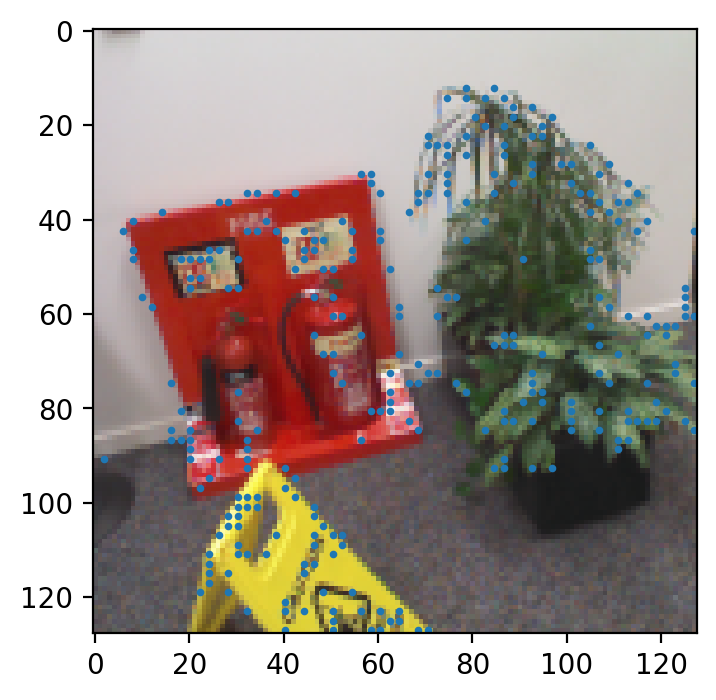

In [51]:
plt.figure(dpi=200)
plt.imshow(input_image)
plt.scatter(keypoints1[:, 0], keypoints1[:, 1], s=3)

In [52]:
input_image.shape

(128, 128, 3)

In [53]:
descriptors1.shape

(288, 240)

In [54]:
matcher = MatchPairNnTorch()

In [55]:
matches = matcher.match_descriptors(descriptors1, descriptors2)
len(matches)

117

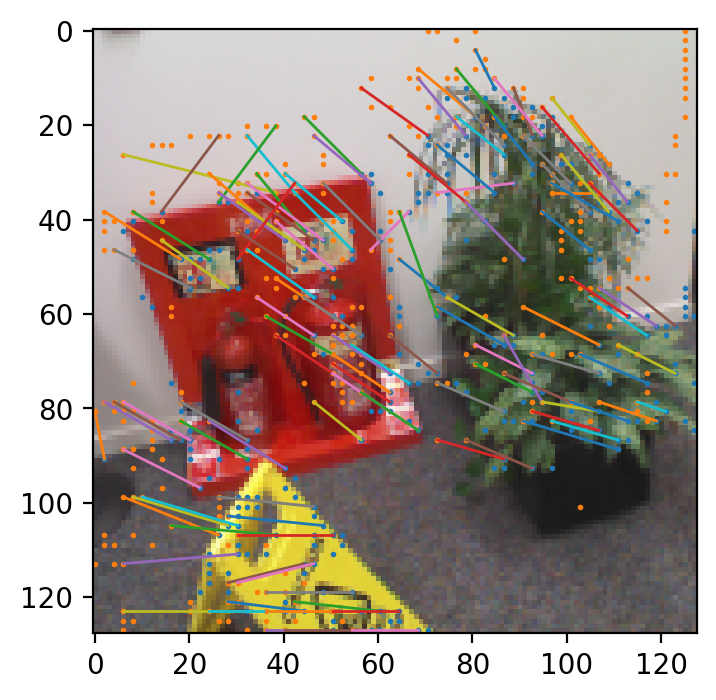

In [56]:
plt.figure(dpi=200)
plt.imshow(input_image)
plt.scatter(keypoints1[:, 0], keypoints1[:, 1], s=1)
plt.scatter(keypoints2[:, 0], keypoints2[:, 1], s=1)
for match in matches:
    plt.plot([keypoints1[int(match[0]), 0], keypoints2[int(match[1]), 0]], 
             [keypoints1[int(match[0]), 1], keypoints2[int(match[1]), 1]], linewidth=1)
# plt.axis('off');

In [57]:
image1 = get_image(batch, 0)
image2 = get_image(batch, 30)

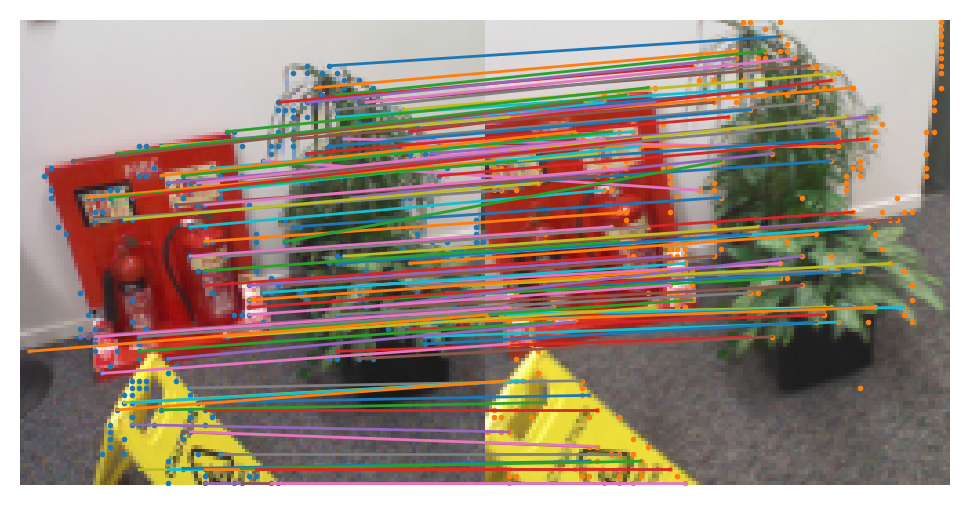

In [58]:
plt.figure(dpi=200)
output_image = np.concatenate([image1, image2], axis=1)

plt.imshow(output_image)
plt.scatter(keypoints1[:, 0], keypoints1[:, 1], s=1)
plt.scatter(keypoints2[:, 0] + 128, keypoints2[:, 1], s=1)
for match in matches:
    plt.plot([keypoints1[int(match[0]), 0], keypoints2[int(match[1]), 0] + 128], 
             [keypoints1[int(match[0]), 1], keypoints2[int(match[1]), 1]], linewidth=1)
plt.axis('off');

# Find transformation

In [59]:
matched_keypoints1 = []
matched_keypoints2 = []
for match in matches:
    matched_keypoints1.append(keypoints1[int(match[0])])
    matched_keypoints2.append(keypoints2[int(match[1])])

matched_keypoints1 = np.array(matched_keypoints1)
matched_keypoints2 = np.array(matched_keypoints2)
matched_keypoints1.shape

(117, 2)

In [60]:
import kornia
import cv2

## Find fundamental

In [61]:
params = cv2.UsacParams() 

In [62]:
# %%timeit
fundamental_matrix, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, params)
# fundamental_matrix, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2)
fundamental_matrix

array([[ 9.82813949e-07,  4.75236667e-05, -1.99736499e-03],
       [-5.31406681e-05, -2.47813842e-05,  2.89183007e-02],
       [ 1.04919648e-03, -2.69329009e-02,  2.81175320e-01]])

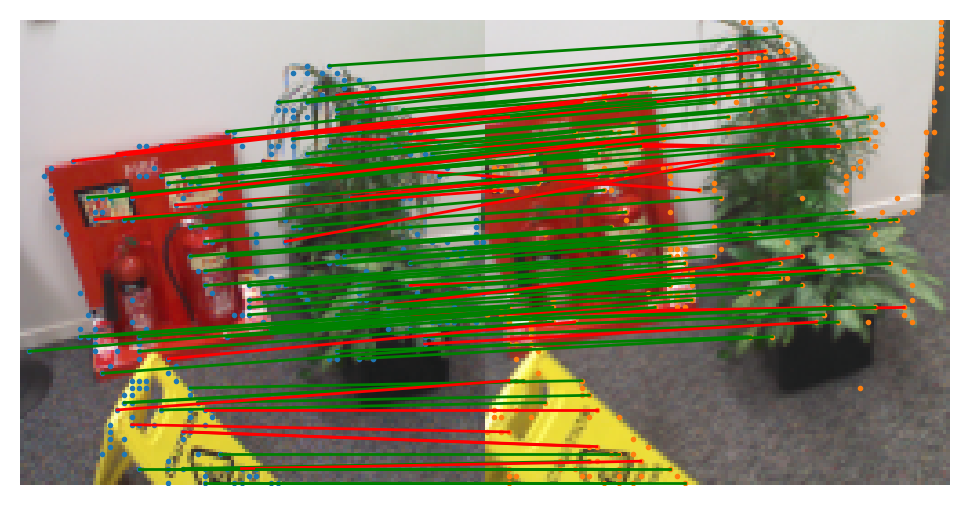

In [63]:
plt.figure(dpi=200)
output_image = np.concatenate([image1, image2], axis=1)

plt.imshow(output_image)
plt.scatter(keypoints1[:, 0], keypoints1[:, 1], s=1)
plt.scatter(keypoints2[:, 0] + 128, keypoints2[:, 1], s=1)
for i, match in enumerate(matches):
    color = "green" if mask[i, 0] else "red" 
    plt.plot([keypoints1[int(match[0]), 0], keypoints2[int(match[1]), 0] + 128], 
             [keypoints1[int(match[0]), 1], keypoints2[int(match[1]), 1]], linewidth=1, c=color)
plt.axis('off');

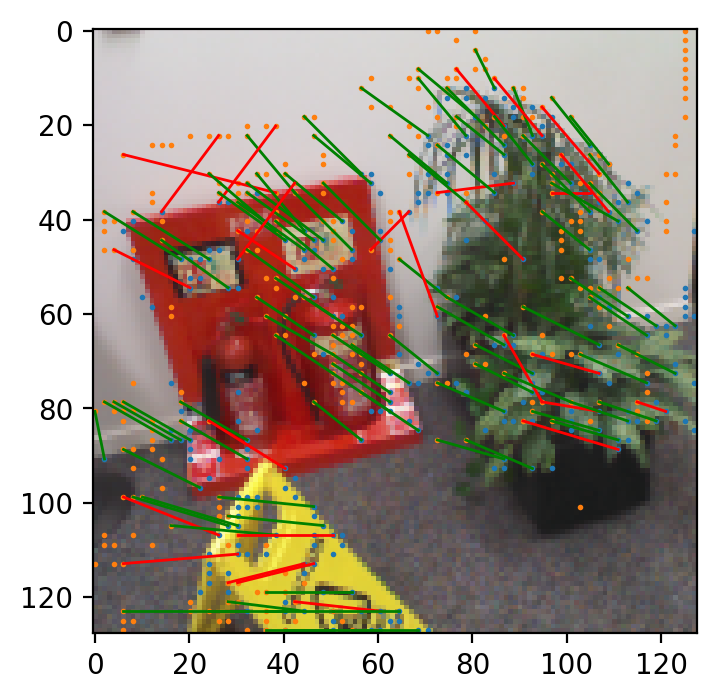

In [64]:
plt.figure(dpi=200)
plt.imshow(input_image)
plt.scatter(keypoints1[:, 0], keypoints1[:, 1], s=1)
plt.scatter(keypoints2[:, 0], keypoints2[:, 1], s=1)
for i, match in enumerate(matches):
    color = "green" if mask[i, 0] else "red" 
    plt.plot([keypoints1[int(match[0]), 0], keypoints2[int(match[1]), 0]], 
             [keypoints1[int(match[0]), 1], keypoints2[int(match[1]), 1]], linewidth=1, c=color)
# plt.axis('off');

In [44]:
focus = 585 / 480. * 128
camera_matrix = np.array([[focus, 0, 64],
                          [0, focus, 64],
                          [0, 0, 1]])
dist_coeffs = np.zeros(5)

In [45]:
fundamental_matrix / fundamental_matrix[-1, -1]

array([[ 4.28733647e-06,  2.44120899e-04,  3.74637631e-03],
       [-2.39972838e-04, -8.99592530e-06,  6.64697655e-02],
       [-8.46215479e-03, -6.67680923e-02,  1.00000000e+00]])

In [46]:
R1 = batch["position"][0:1, :3, :3].transpose(1, 2)
t1 = -torch.bmm(R1, batch["position"][0:1, :3, 3:4])
R2 = batch["position"][30:31, :3, :3].transpose(1, 2)
t2 = -torch.bmm(R2, batch["position"][30:31, :3, 3:4])
projection1 = kornia.geometry.epipolar.projection_from_KRt(torch.tensor(camera_matrix)[None], 
                                                           R1, 
                                                           t1)
projection2 = kornia.geometry.epipolar.projection_from_KRt(torch.tensor(camera_matrix)[None], 
                                                           R2, 
                                                           t2)
truth_fundamental_matrix = kornia.geometry.epipolar.fundamental_from_projections(projection1, projection2)
truth_fundamental_matrix / truth_fundamental_matrix[:, -1, -1]

tensor([[[ 4.7498e-06,  2.4576e-04,  6.9060e-03],
         [-2.2461e-04,  2.2605e-05,  4.8235e-02],
         [-1.2562e-02, -5.1481e-02,  1.0000e+00]]], dtype=torch.float64)

## Find essential matrix

In [61]:
R1 = batch["position"][0:1, :3, :3].transpose(1, 2)
t1 = -torch.bmm(R1, batch["position"][0:1, :3, 3:4])
R2 = batch["position"][30:31, :3, :3].transpose(1, 2)
t2 = -torch.bmm(R2, batch["position"][30:31, :3, 3:4])
# R1 = batch["position"][0:1, :3, :3]
# t1 = batch["position"][0:1, :3, 3:4]
# R2 = batch["position"][30:31, :3, :3]
# t2 = batch["position"][30:31, :3, 3:4]
truth_essential_matrix = kornia.geometry.epipolar.essential_from_Rt(R1, t1, R2, t2)
truth_essential_matrix / truth_essential_matrix[:, -1, -1]

tensor([[[ 0.1838,  9.5100,  5.6911],
         [-8.6915,  0.8747,  8.7574],
         [-6.6076, -8.5091,  1.0000]]], dtype=torch.float64)

In [48]:
essential_matrix, _ = cv2.findEssentialMat(matched_keypoints1, matched_keypoints2, camera_matrix)
essential_matrix / essential_matrix[-1, -1]

array([[  0.85350128,  33.61572639,   3.2572435 ],
       [-32.70563269,   1.40873341,  13.55214879],
       [ -5.52984137, -11.79711622,   1.        ]])

In [49]:
essential_matrix1 = kornia.geometry.epipolar.essential_from_fundamental(torch.tensor(fundamental_matrix[None]),
                                                    torch.tensor(camera_matrix)[None],
                                                    torch.tensor(camera_matrix)[None])
essential_matrix1 / essential_matrix1[:, -1, -1]

tensor([[[  0.1542,   8.7779,   4.5280],
         [ -8.6288,  -0.3235,  11.6483],
         [ -5.4273, -11.9213,   1.0000]]], dtype=torch.float64)

## Find relative

In [50]:
retval, R, t, _ = cv2.recoverPose(essential_matrix, matched_keypoints1, matched_keypoints2, camera_matrix, 
                                     mask=mask)
print(R.T)
print(t)
print(-R.T @ t)

[[ 0.99855228  0.01745619  0.05087848]
 [-0.02053595  0.99794774  0.0606514 ]
 [-0.04971532 -0.06160843  0.99686147]]
[[-0.33300122]
 [ 0.14874296]
 [-0.93112068]]
[[ 0.37729665]
 [-0.09880243]
 [ 0.92080688]]


In [51]:
position1 = batch["position"][0].detach().cpu().numpy()
position2 = batch["position"][30].detach().cpu().numpy()
relative_position = np.linalg.inv(position2) @ position1
print(relative_position)
print(relative_position[:3, 3] / np.linalg.norm(relative_position[:3, 3]))

[[ 0.99968176 -0.00442724 -0.02489294 -0.10682355]
 [ 0.00198133  0.99524111 -0.09743572  0.08207001]
 [ 0.02520573  0.09735532  0.9949319  -0.1109433 ]
 [ 0.          0.          0.          1.        ]]
[-0.61211986  0.47027721 -0.63572684]


In [59]:
kornia.geometry.epipolar.decompose_essential_matrix(essential_matrix1)

(tensor([[[ 0.1589, -0.4752,  0.8654],
          [-0.5053, -0.7922, -0.3422],
          [ 0.8482, -0.3830, -0.3660]]], dtype=torch.float64),
 tensor([[[ 0.9996,  0.0187, -0.0199],
          [-0.0195,  0.9990, -0.0409],
          [ 0.0191,  0.0412,  0.9990]]], dtype=torch.float64),
 tensor([[[ 0.7526],
          [-0.3409],
          [ 0.5634]]], dtype=torch.float64))

In [58]:
kornia.geometry.epipolar.decompose_essential_matrix(truth_essential_matrix)

(tensor([[[ 0.9997, -0.0044, -0.0249],
          [ 0.0020,  0.9952, -0.0974],
          [ 0.0252,  0.0974,  0.9949]]], dtype=torch.float64),
 tensor([[[-0.2322, -0.4962,  0.8366],
          [-0.5918, -0.6106, -0.5263],
          [ 0.7719, -0.6173, -0.1518]]], dtype=torch.float64),
 tensor([[[ 0.6121],
          [-0.4704],
          [ 0.6357]]], dtype=torch.float64))